In [2]:
# MNIST CNN Training with PyTorch on Apple M4
# Optimized for Apple Silicon MPS backend

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from tqdm import tqdm
import time
import importlib

from ml_modules import data
importlib.reload(data)

from ml_modules import models
importlib.reload(models)

from ml_modules import visualize
importlib.reload(visualize)

from ml_modules import train
importlib.reload(train)

# Check for Apple Silicon MPS availability
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Set device - prioritize MPS for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

PyTorch version: 2.7.1
MPS available: True
MPS built: True
Using Apple Silicon MPS


In [3]:
mnist_train_loader, mnist_test_loader, cifar_data_info = data.get_mnist_loaders(batch_size=1)
test_iter = iter(mnist_test_loader)

In [4]:
importlib.reload(models)
model = models.ToyCNN().to(device)

In [5]:
input, num = next(test_iter)
input_mps, target_mps = input.to(device, non_blocking=True), num.to(device, non_blocking=True)

target, _ = next(test_iter)
target_mps = target.to(device, non_blocking=True)


In [6]:
input.shape

torch.Size([1, 1, 28, 28])

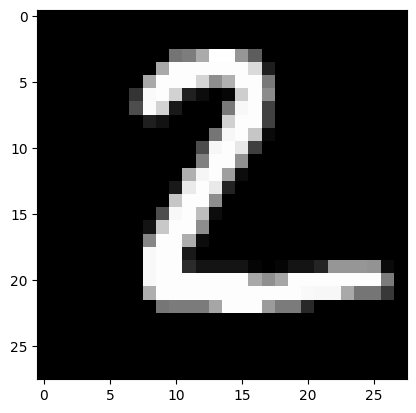

In [7]:
plt.imshow(target.squeeze(),cmap="gray")

In [8]:
importlib.reload(models)
model = models.ToyCNN().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

losses = []

for i in range(3000):

    optimizer.zero_grad()
    
    out = model(input_mps)

    loss =  ((out - target_mps) * (out - target_mps)).sum()

    

    loss.backward()

    losses.append(loss.item())

    optimizer.step()


    out_cpu = out.to('cpu')

    if i % 100 == 0:
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(input.squeeze(), cmap='gray')
        axs[1].imshow(out_cpu.detach().numpy().squeeze(), cmap='gray')



ax = plt.subplot()
ax.plot(losses)

RuntimeError: Given groups=1, weight of size [1, 5, 3, 3], expected input[1, 1, 28, 28] to have 5 channels, but got 1 channels instead

In [9]:
test_iter = iter(mnist_test_loader)

filtered_classes = []
target_class = 2

for data, target in test_iter:
    if target == 2:
        filtered_classes.append(data)
    

len(filtered_classes)


1032

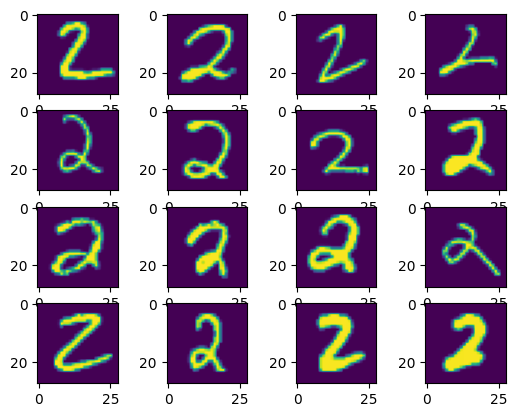

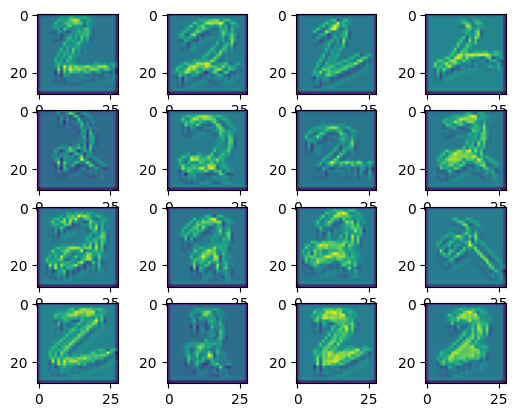

In [10]:
fig, axs = plt.subplots(4,4)
for i in range(16):
    row, col = i // 4, i % 4
    axs[row,col].imshow(filtered_classes[i].squeeze())


fig, axs = plt.subplots(4,4)
for i in range(16):
    row, col = i // 4, i % 4

    predict = model(filtered_classes[i].to(device))
    predict = predict.detach().cpu().numpy().squeeze()

    axs[row,col].imshow(predict)